# 4.1b Compare CLD with other works

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import report
import block_sampler
import batch_encoder
import callbacks
from dataset import Dataset

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, TimeDistributed, Flatten, Dot, Softmax, Lambda, RepeatVector, Multiply, Permute, Reshape, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from trainer import TrainResults

In [2]:
tf.__version__, tf.keras.__version__

('1.14.0', '2.2.4-tf')

In [3]:
tf.test.is_gpu_available(), tf.test.is_built_with_cuda()

(False, False)

In [4]:
raw_dataset_folder='/home/user/sample200/'
minimum=200
maximum=200
result_dir = 'results/4.1b-compare-other-works'
os.makedirs(result_dir, exist_ok=True)

In [5]:
rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(minimum, maximum)
rawset = rawset.filter(lambda x: rawset.category_from(x) not in ['text', 'unk'])
rawset.rebuild_categories()

In [6]:
tset, vset = rawset.rnd_split_fraction_by_category(0.5)

In [7]:
def CLD(classes, len_byte_vector):
    last = l0 = Input(shape=(512,len_byte_vector))
    last = Conv1D(256, (16,), strides=16)(last)
    last = LSTM(128)(last)
    last = Dense(classes)(last)
    last = Activation('softmax')(last)
    name = sys._getframe().f_code.co_name
    model = tf.keras.Model([l0], last, name=name)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['binary_accuracy', 'categorical_accuracy'])
    return model

In [8]:
class MyTrainer:
    def __init__(self,
                 model,
                 group_by='by_file',
                 xs_encoder='8bits_11',
                 validation_steps=10,
                 steps_per_epoch=28,
                 epochs=10000000,
                 max_seconds=None,
                 batch_size=100,
                 min_delta=1e-03,
                 patience=10,
                 blockSampler=block_sampler.BlockSampler,
                 batchEncoder=batch_encoder.BatchEncoder):
        self.model = model
        self.group_by = group_by
        self.xs_encoder = xs_encoder
        self.validation_steps = validation_steps
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.max_seconds = max_seconds
        self.batch_size = batch_size
        self.min_delta = min_delta
        self.patience = patience
        self.blockSampler = blockSampler
        self.batchEncoder = batchEncoder

    def train(self, tset, vset):
        tsampler = self.blockSampler(tset, group_by=self.group_by)
        tbenc = self.batchEncoder(tsampler, self.batch_size,
                                  xs_encoder=self.xs_encoder)

        vsampler = self.blockSampler(vset, group_by=self.group_by)
        vbenc = self.batchEncoder(vsampler, self.batch_size,
                                  xs_encoder=self.xs_encoder)

        model = self.model

        timeIt = callbacks.TimeIt()

        history = model.fit_generator(iter(tbenc),
                                      validation_data=iter(vbenc),
                                      validation_steps=self.validation_steps,
                                      steps_per_epoch=self.steps_per_epoch,
                                      epochs=self.epochs,
                                      verbose=0,
                                      callbacks=[
            timeIt,
            # callbacks.SaveModel(os.path.join(result_dir, model.name + '.h5')),
#             callbacks.TimeLimit(self.max_seconds),
            EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=self.min_delta, patience=self.patience),
            TensorBoard(
                log_dir=os.path.join(result_dir, model.name),
            ),
        ],
#             use_multiprocessing=False,
#             workers=0,
        )
        return TrainResults(
            model=model,
            history=history,
            metrics=['val_binary_accuracy', 'val_categorical_accuracy'],
            elapsed=timeIt.elapsed,
        )

In [9]:
def train(categories):
    rawset = Dataset.new_from_folders(raw_dataset_folder).filter_min_max(0, maximum)
    rawset = rawset.filter(lambda x: rawset.category_from(x) in categories)
    rawset.rebuild_categories()

    tset, vset = rawset.rnd_split_fraction_by_category(0.5)

    model = CLD(len(categories),256)

    result = MyTrainer(
            model,
            xs_encoder='one_hot',
            batch_size=200,
            steps_per_epoch=len(categories),
            validation_steps=len(categories),
            patience=20,
        ).train(tset, vset)
    return result

# start report

In [10]:
if os.path.exists(result_dir + '/compare.csv'):
    os.remove(result_dir + '/compare.csv')
r = report.Reporter2(result_dir + '/compare.csv')

# this study

In [11]:
categories = ['csv', 'dbase3', 'doc', 'dwf', 'eps', 'f', 'gif', 'gz', 'hlp', 'html', 'java', 'jpg', 'kml', 'kmz',
              'log', 'pdf', 'png', 'pps', 'ppt', 'pptx', 'ps', 'rtf', 'sql', 'swf', 'txt', 'wp', 'xls', 'xml']

In [12]:
result = train(categories)
r.line(study='this study',
       time=result.elapsed,
       val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1])

W1106 17:46:53.857207 140420200638272 deprecation.py:506] From /home/user/.local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1106 17:46:54.724305 140420200638272 deprecation.py:323] From /home/user/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])

4701.547247648239 0.61160713


# Chen

In [14]:
categories = ["csv", "doc", "docx", "gif", "gz", "html", "java", "jpg", 
              "log", "pdf", "png", "ppt", "rtf", "text", "xls", "xml"]

In [15]:
result = train(categories)
r.line(study='Chen',
       time=result.elapsed,
       val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1])

In [16]:
print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])

2011.257327079773 0.628125


# Hiester
csv, xml, jpg and gif.

In [17]:
categories = ['csv', 'xml', 'jpg', 'gif']

In [18]:
result = train(categories)
r.line(study='Hiester',
       time=result.elapsed,
       val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1])

In [19]:
print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])

494.6045982837677 0.88625


# Wang wang_sparse_2018
csv, doc, docx, gif, gz, html, jpg, pdf, png, ppt, pptx, ps, rtf, swf, txt, xls, xlsx, and xml.

In [20]:
categories = ['csv', 'doc', 'docx', 'gif', 'gz', 'html', 'jpg', 'pdf', 'png', 'ppt', 'pptx',
              'ps', 'rtf', 'swf', 'txt', 'xls', 'xlsx', 'xml']

In [21]:
result = train(categories)
r.line(study='Wang-sparse',
       time=result.elapsed,
       val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1])

In [22]:
print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])

2922.1834766864777 0.58111113


# Wang wang_file_2018
csv, doc, html, pdf, gif, jpg, dbase3, f, txt, swf, ps, java, log, xml, xls, ppt, gz, unk, rtf, and png.


In [23]:
categories = ['csv', 'doc', 'html', 'pdf', 'gif', 'jpg', 'dbase3', 'f', 'txt', 'swf', 'ps', 'java', 'log', 'xml', 'xls', 'ppt', 'gz', 'unk', 'rtf', 'png']

In [24]:
result = train(categories)
r.line(study='Wang-file',
       time=result.elapsed,
       val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1])

In [25]:
print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])

2142.339622735977 0.61025


 # Vulinović
csv, doc, docx, gif, gz, html, jpg, pdf, png, ppt, pptx, ps, rtf, swf, txt, xls, xlsx, and xml.

In [26]:
categories = ['csv', 'doc', 'docx', 'gif', 'gz', 'html', 'jpg', 'pdf', 'png', 'ppt', 'pptx', 'ps', 'rtf', 'swf', 'txt', 'xls', 'xlsx', 'xml']

In [27]:
result = train(categories)
r.line(study='Vulinovic',
       time=result.elapsed,
       val_categorical_accuracy=result.history.history['val_categorical_accuracy'][-1])

In [28]:
print(result.elapsed, result.history.history['val_categorical_accuracy'][-1])

3179.7913019657135 0.57222223


# close report

In [ ]:
r.close()

# Load data

In [53]:
data = pd.read_csv(result_dir + '/compare.csv', sep='\t')
data

,study,time,val_categorical_accuracy
0,this study,4701.547248,0.611607
1,Chen,2011.257327,0.628125
2,Hiester,494.604598,0.886250
3,Wang-sparse,2922.183477,0.581111
4,Wang-file,2142.339623,0.610250
5,Vulinovic,3179.791302,0.572222


In [57]:
data.set_value(0,'study', '28 file types')
data['CLD'] = data['val_categorical_accuracy']
data['their results'] = [0, 0.71, 0.98, 0.61, 0.68, 0.61]
data

/home/atila.alr/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """Entry point for launching an IPython kernel.


,study,time,val_categorical_accuracy,CLD,their results
0,28 file types,4701.547248,0.611607,0.611607,0.00
1,Chen,2011.257327,0.628125,0.628125,0.71
2,Hiester,494.604598,0.886250,0.886250,0.98
3,Wang-sparse,2922.183477,0.581111,0.581111,0.61
4,Wang-file,2142.339623,0.610250,0.610250,0.68
5,Vulinovic,3179.791302,0.572222,0.572222,0.61


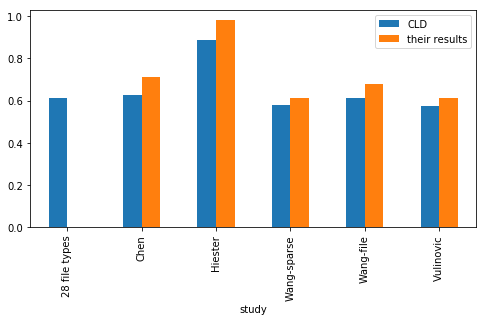

In [58]:
data.plot.bar('study', ['CLD', 'their results'], figsize=(8,4))
plt.show()